# Tensor Flow Notebook
## W207 Final Project
### T. P. Goter
### July 15, 2019

This workbook is used to create convolutional neural nets for facial keypoint detection on CPUs (not TPUs).

In [2]:
# Import needed packages
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras import optimizers, metrics
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
tf.__version__
tf.keras.backend.clear_session()

## Data Loading

- Load in the pickle file that was created as part of the EDA in DataExploration.ipynb. 
- This dataset has the NaNs removed and a few mislabeled images removed as well. 
- As such there is only limited training and development data to use. 
- The image data has already been normalized to [0,1]

In [4]:
# Initialize Random Seed for reproducibility
np.random.seed(13)

# Load the dataframe from the pickle file
df_nostache_nonan = pd.read_pickle("df_nostache_nonan.pkl")

# Grab the last column - that is our image data for X matrix
X = df_nostache_nonan.iloc[:, -1]

# Convert from a series of arrays to an NDarray
X = np.array([x.reshape(96,96,1) for x in X])

# Grab the keypoints and stick into our y-variable
y = np.array(df_nostache_nonan.iloc[:,:-1])
# y = (y - 48) / 48  # scale target coordinates to [-1, 1]

In [8]:
df_nostache_nonan

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.328960,36.912768,32.007040,35.196608,59.751040,38.342848,71.477760,37.198784,36.869120,36.912768,...,62.940800,58.606720,76.955520,31.434880,75.811840,45.163520,74.095360,44.019840,84.392320,"[0.5372549019607843, 0.5411764705882353, 0.537..."
1,64.918419,38.881725,28.223425,36.297772,58.457677,39.399090,71.378587,39.915880,33.908695,37.331353,...,59.813174,56.907305,83.587257,32.616431,82.295569,45.278659,77.385772,45.278659,92.373269,"[0.7450980392156863, 0.4823529411764706, 0.572..."
2,67.690269,35.696894,29.502277,37.127950,60.322981,36.359420,75.983503,37.477234,39.095652,37.684472,...,60.597097,68.056859,71.180585,33.458101,74.460088,50.136717,76.991396,49.879042,77.060266,"[0.0196078431372549, 0.00784313725490196, 0.01..."
3,65.265185,35.172741,29.512889,33.319111,59.173926,36.232296,70.826667,36.497185,35.604148,34.113778,...,55.829926,58.644741,71.455407,33.749926,70.395852,46.197333,67.747556,45.932444,78.340741,"[0.43137254901960786, 0.44313725490196076, 0.3..."
4,62.477241,41.666207,27.873103,34.604138,58.637241,40.960000,72.376497,44.003752,39.313655,37.846069,...,55.906545,57.770074,77.269048,32.047118,73.298886,47.632311,73.206557,47.724641,74.166782,"[0.27450980392156865, 0.32941176470588235, 0.3..."
5,65.476354,39.960816,30.590259,35.764680,59.183673,40.359184,72.593197,41.142857,35.804082,36.457143,...,55.580952,57.662966,77.396136,27.432925,72.925551,43.114286,73.676190,42.813605,75.427211,"[0.8862745098039215, 0.8823529411764706, 0.866..."
6,68.143680,40.385280,29.429440,38.747520,60.996480,40.832000,76.035200,42.470080,37.618880,39.491840,...,57.509120,63.825600,79.248640,33.152000,78.355200,49.725120,73.580480,49.530880,83.268800,"[0.6980392156862745, 0.30196078431372547, 0.18..."
7,63.812741,36.945185,31.237926,36.680296,59.045333,36.945185,69.639111,37.474963,36.269630,37.210074,...,59.985778,62.488296,70.049185,36.004741,69.784296,49.246815,66.077037,49.511704,75.345778,"[0.803921568627451, 0.8117647058823529, 0.8156..."
8,59.210904,34.925801,30.399355,42.995118,53.374645,37.602033,64.831565,33.696265,36.809501,42.665471,...,56.709023,67.113590,70.542162,40.077170,79.616248,57.191154,75.232758,56.219962,75.862721,"[0.5450980392156862, 0.5568627450980392, 0.549..."
9,67.295312,34.149161,30.030452,35.695484,57.399398,36.159312,77.346065,35.076817,39.617376,36.623140,...,59.817290,64.975828,73.424172,35.132903,75.279828,47.657634,72.187183,48.430796,80.382280,"[0.6627450980392157, 0.43137254901960786, 0.27..."


In [4]:
X.shape

(2140, 96, 96, 1)

## Baseline Neural Net
CNNs are combinations of convolution layers, pooling layers and dropout layers followed by one or two fully connected layers once the number of dimensions has been sufficiently reduced.

1. Let's include just one hidden layer and one output layer
2. The input layer will reduce our flattened 96x96 matrix (i.e., 9216 in length) to a predetermined number of hidden units
3. We will then run sensitivities to # of hidden units, activation, optimizer, and learning rate
4. We will judge our model based on RMSE error and run time.

In [19]:
def create_cnn_model():
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    cnn_model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Conv2D(64, (2, 2), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Conv2D(128, (2, 2), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(30))
    cnn_model.add(tf.keras.layers.Activation('linear'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
  
    return cnn_model
   
class TimeHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [6]:
def create_bad_cnn_model():
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    cnn_model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Conv2D(64, (2, 2), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Conv2D(128, (2, 2), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(30))
    cnn_model.add(tf.keras.layers.Activation('relu'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
  
    return cnn_model

#### Define our optimizers for our initial study

In [17]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
sgd = optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True)
nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

opt_list = {'adam':adam,'sgd':sgd, 'nadam':nadam, 'adagrad':adagrad}
#opt_list = {'adam':adam}

#### Set up our first DOE

In [ ]:
time_callback = TimeHistory()
cnn_base_df = pd.DataFrame()
for opt_name, opt in opt_list.items():
    model = create_cnn_model()
    model.compile(
          optimizer=opt_list['adam'],
          loss='mean_squared_error',
          metrics=['mean_squared_error'])
    history = model.fit(
        X.astype(np.float32), y.astype(np.float32),
        epochs=200,
        validation_split=0.15, callbacks=[time_callback])
    times = time_callback.times
    
    # Convert to dataframe
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist['RMSE'] = np.sqrt(hist.mean_squared_error)
    hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
    hist['times'] = times
    hist['layers'] = 3
    hist['pooling'] = 'yes'
    hist['fc_layer'] = 500
    hist['activation'] = 'relu'
    hist['optimizer'] = opt_name
    hist['lrate'] = opt.get_config()['learning_rate']
    
    # Keep concatenating to dataframe
    cnn_base_df = pd.concat([cnn_base_df,hist])

    # Re-pickle after every model to retain progress
    cnn_base_df.to_pickle("OutputData/cnn_base_df.pkl")

    # Save models.
    filename = "cnn_model_{}".format( opt_name)
    model.save("Models/"+filename+".h5")
    

# Run with RELU output activation to show issue

In [10]:
time_callback = TimeHistory()
cnn_relu_df = pd.DataFrame()
for opt_name, opt in opt_list.items():
    model = create_bad_cnn_model()
    model.compile(
          optimizer=opt_list['adam'],
          loss='mean_squared_error',
          metrics=['mean_squared_error'])
    history = model.fit(
        X.astype(np.float32), y.astype(np.float32),
        epochs=200,
        validation_split=0.15, callbacks=[time_callback])
    times = time_callback.times
    
    # Convert to dataframe
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist['RMSE'] = np.sqrt(hist.mean_squared_error)
    hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
    hist['times'] = times
    hist['layers'] = 3
    hist['pooling'] = 'yes'
    hist['fc_layer'] = 500
    hist['activation'] = 'relu'
    hist['optimizer'] = opt_name
    hist['lrate'] = opt.get_config()['learning_rate']
    
    # Keep concatenating to dataframe
    cnn_relu_df = pd.concat([cnn_relu_df,hist])

    # Re-pickle after every model to retain progress
    cnn_relu_df.to_pickle("OutputData/cnn_relu_df.pkl")

    # Save models.
    filename = "bad_cnn_model_{}".format( opt_name)
    model.save("Models/"+filename+".h5")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 128)       32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 15488)             0

Epoch 35/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 575.5777 - mean_squared_error: 575.5776 - val_loss: 574.2953 - val_mean_squared_error: 574.2953
Epoch 36/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 575.6989 - mean_squared_error: 575.6989 - val_loss: 574.2664 - val_mean_squared_error: 574.2664
Epoch 37/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 575.5464 - mean_squared_error: 575.5464 - val_loss: 574.8460 - val_mean_squared_error: 574.8460
Epoch 38/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 575.6901 - mean_squared_error: 575.6901 - val_loss: 574.2470 - val_mean_squared_error: 574.2469
Epoch 39/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 575.6243 - mean_squared_error: 575.6243 - val_loss: 574.6216 - val_mean_squared_error: 574.6215
Epoch 40/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 575.3692 - mean_squared_error: 575

1819/1819 [==============================] - 10s 5ms/sample - loss: 573.9944 - mean_squared_error: 573.9945 - val_loss: 573.8156 - val_mean_squared_error: 573.8156
Epoch 128/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 573.9754 - mean_squared_error: 573.9754 - val_loss: 573.8170 - val_mean_squared_error: 573.8170
Epoch 129/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 573.9351 - mean_squared_error: 573.9350 - val_loss: 573.7995 - val_mean_squared_error: 573.7995
Epoch 130/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 573.9019 - mean_squared_error: 573.9019 - val_loss: 573.8474 - val_mean_squared_error: 573.8474
Epoch 131/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 574.0116 - mean_squared_error: 574.0117 - val_loss: 573.8295 - val_mean_squared_error: 573.8295
Epoch 132/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 573.9431 - mean_squared_error: 573.9429 - 

In [26]:
predictions = model.predict(X[-5:])

In [27]:
predictions.shape

(5, 30)

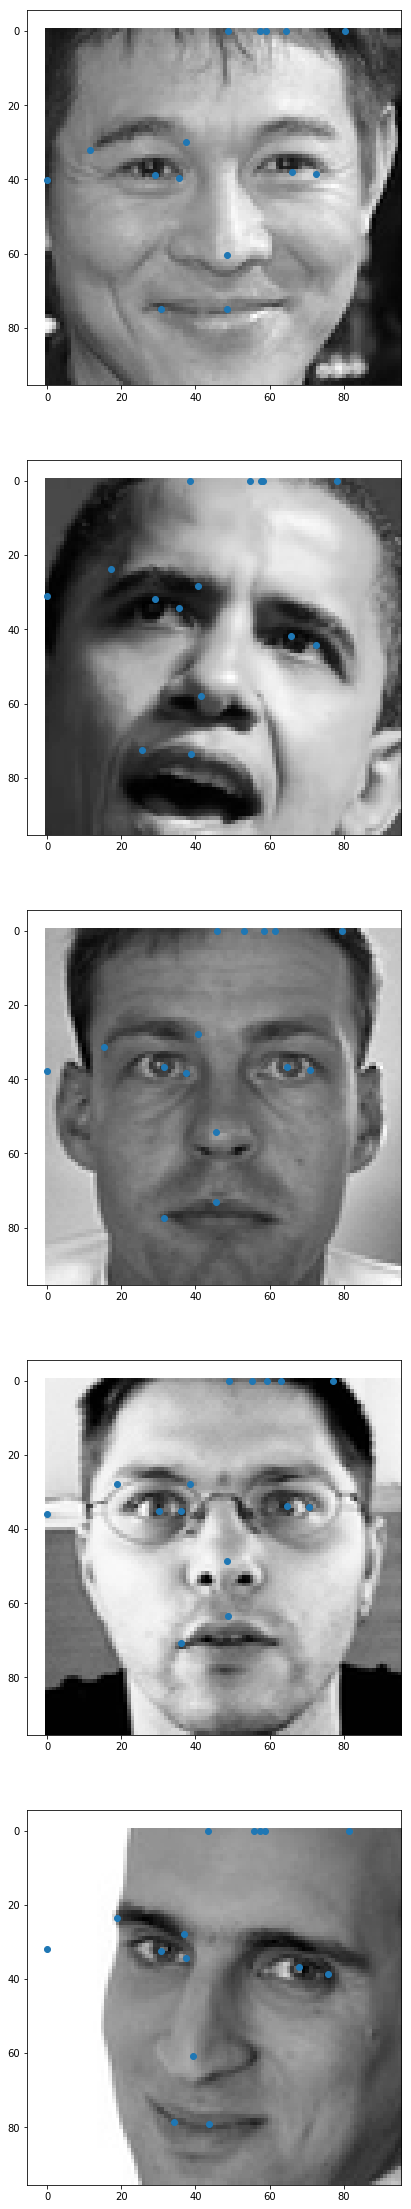

In [28]:
fig, axes = plt.subplots(len(predictions), 1, figsize=(8,8*len(predictions)))
axes = axes.flatten()
xs = predictions[:,0:30:2]
ys = predictions[:,1:30:2]
for i, ax in enumerate(axes):
    ax.imshow(np.reshape(X[-5+i],(96,96)), origin='upper', cmap='gray')
    ax.scatter(x=xs[i,:], y=ys[i,:])


In [32]:
def create_filter_cnn_model(start_filters=32):
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    cnn_model.add(tf.keras.layers.Conv2D(start_filters, (3, 3), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Conv2D(start_filters*2, (2, 2), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Conv2D(start_filters*4, (2, 2), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(30))
    cnn_model.add(tf.keras.layers.Activation('linear'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
  
    return cnn_model

In [33]:
# Redefine optimizer list to just focus on adam and sgd
opt_list = {'adam':adam,'sgd':sgd}

# Use an early stopping callback and our timing callback
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1,
                              patience=100, mode='auto')
time_callback = TimeHistory()

# Initialize a new data frame to hold our output data
cnn_filter_df = pd.DataFrame()

# Let's try a range of starting filter sizes from 3 to 16 (our baseline had 32)
n_filters = [3, 5, 12, 16]
for n in n_filters:
    for opt_name, opt in opt_list.items():
        model = create_filter_cnn_model(start_filters=n)
        model.compile(
              optimizer=opt,
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
        history = model.fit(
            X.astype(np.float32), y.astype(np.float32),
            epochs=200,
            validation_split=0.15, callbacks=[time_callback, early_stop])
        times = time_callback.times

        # Convert to dataframe
        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch
        hist['RMSE'] = np.sqrt(hist.mean_squared_error)
        hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
        hist['times'] = times
        hist['starting_filter'] = n
        hist['layers'] = 3
        hist['pooling'] = 'yes'
        hist['fc_layer'] = 500
        hist['activation'] = 'relu'
        hist['optimizer'] = opt_name
        hist['lrate'] = opt.get_config()['learning_rate']

        # Keep concatenating to dataframe
        cnn_filter_df = pd.concat([cnn_filter_df,hist])

        # Re-pickle after every model to retain progress
        cnn_filter_df.to_pickle("OutputData/cnn_filter_df.pkl")

        # Save models.
        filename = "filter_cnn_model_{}_{}filters".format(opt_name, n)
        model.save("Models/"+filename+".h5")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 94, 94, 3)         30        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 47, 47, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 46, 6)         78        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 6)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 22, 22, 12)        300       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 11, 11, 12)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1452)             

Epoch 85/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 2.4876 - mean_squared_error: 2.4876 - val_loss: 3.5072 - val_mean_squared_error: 3.5072
Epoch 86/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 2.4113 - mean_squared_error: 2.4113 - val_loss: 3.7545 - val_mean_squared_error: 3.7545
Epoch 87/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 2.3089 - mean_squared_error: 2.3089 - val_loss: 3.3849 - val_mean_squared_error: 3.3849
Epoch 88/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 2.4857 - mean_squared_error: 2.4857 - val_loss: 3.5103 - val_mean_squared_error: 3.5103
Epoch 89/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 2.3594 - mean_squared_error: 2.3594 - val_loss: 3.3016 - val_mean_squared_error: 3.3016
Epoch 90/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 2.2927 - mean_squared_error: 2.2927 - val_loss: 3.5252 - val_mean_squared_error:

1819/1819 [==============================] - 2s 1ms/sample - loss: 0.8882 - mean_squared_error: 0.8882 - val_loss: 3.0707 - val_mean_squared_error: 3.0707
Epoch 182/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 0.8087 - mean_squared_error: 0.8087 - val_loss: 3.0416 - val_mean_squared_error: 3.0416
Epoch 183/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 0.7892 - mean_squared_error: 0.7892 - val_loss: 3.2756 - val_mean_squared_error: 3.2756
Epoch 184/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 0.8630 - mean_squared_error: 0.8630 - val_loss: 3.0708 - val_mean_squared_error: 3.0708
Epoch 185/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 0.7692 - mean_squared_error: 0.7692 - val_loss: 3.0278 - val_mean_squared_error: 3.0278
Epoch 186/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 0.7665 - mean_squared_error: 0.7665 - val_loss: 3.1422 - val_mean_squared_error: 3.1422


Epoch 15/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 1050.9138 - mean_squared_error: 1050.9138 - val_loss: 677.7497 - val_mean_squared_error: 677.7498
Epoch 16/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 473.3040 - mean_squared_error: 473.3041 - val_loss: 306.5498 - val_mean_squared_error: 306.5498
Epoch 17/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 216.2328 - mean_squared_error: 216.2328 - val_loss: 141.6104 - val_mean_squared_error: 141.6104
Epoch 18/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 101.8305 - mean_squared_error: 101.8305 - val_loss: 68.3015 - val_mean_squared_error: 68.3015
Epoch 19/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 50.9596 - mean_squared_error: 50.9596 - val_loss: 35.6806 - val_mean_squared_error: 35.6806
Epoch 20/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 28.3154 - mean_squared_error: 28.3154 - val_

Epoch 63/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 10.1895 - mean_squared_error: 10.1895 - val_loss: 9.8837 - val_mean_squared_error: 9.8837
Epoch 64/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 10.1891 - mean_squared_error: 10.1891 - val_loss: 9.8841 - val_mean_squared_error: 9.8841
Epoch 65/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 10.1890 - mean_squared_error: 10.1890 - val_loss: 9.8840 - val_mean_squared_error: 9.8840
Epoch 66/200
1819/1819 [==============================] - 3s 1ms/sample - loss: 10.1893 - mean_squared_error: 10.1893 - val_loss: 9.8829 - val_mean_squared_error: 9.8829
Epoch 67/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 10.1892 - mean_squared_error: 10.1892 - val_loss: 9.8839 - val_mean_squared_error: 9.8839
Epoch 68/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 10.1890 - mean_squared_error: 10.1890 - val_loss: 9.8845 - val_mean_sq

1819/1819 [==============================] - 3s 2ms/sample - loss: 8.9140 - mean_squared_error: 8.9140 - val_loss: 8.7684 - val_mean_squared_error: 8.7684
Epoch 20/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 8.7044 - mean_squared_error: 8.7044 - val_loss: 8.9578 - val_mean_squared_error: 8.9578
Epoch 21/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 8.5022 - mean_squared_error: 8.5022 - val_loss: 8.5452 - val_mean_squared_error: 8.5452
Epoch 22/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 8.4160 - mean_squared_error: 8.4160 - val_loss: 8.5869 - val_mean_squared_error: 8.5869
Epoch 23/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 8.3058 - mean_squared_error: 8.3058 - val_loss: 8.1946 - val_mean_squared_error: 8.1946
Epoch 24/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 8.0228 - mean_squared_error: 8.0228 - val_loss: 8.4364 - val_mean_squared_error: 8.4364
Epoch

Epoch 68/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 3.8082 - mean_squared_error: 3.8082 - val_loss: 4.3932 - val_mean_squared_error: 4.3932
Epoch 69/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 3.8425 - mean_squared_error: 3.8425 - val_loss: 4.2441 - val_mean_squared_error: 4.2441
Epoch 70/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 3.6345 - mean_squared_error: 3.6345 - val_loss: 4.8376 - val_mean_squared_error: 4.8376
Epoch 71/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 3.7103 - mean_squared_error: 3.7103 - val_loss: 4.9922 - val_mean_squared_error: 4.9922
Epoch 72/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 3.6714 - mean_squared_error: 3.6714 - val_loss: 4.1341 - val_mean_squared_error: 4.1341
Epoch 73/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 3.5675 - mean_squared_error: 3.5675 - val_loss: 4.0222 - val_mean_squared_error:

Epoch 117/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 2.2437 - mean_squared_error: 2.2437 - val_loss: 3.4887 - val_mean_squared_error: 3.4887
Epoch 118/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 2.2471 - mean_squared_error: 2.2471 - val_loss: 3.4721 - val_mean_squared_error: 3.4721
Epoch 119/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 2.2592 - mean_squared_error: 2.2592 - val_loss: 3.2886 - val_mean_squared_error: 3.2886
Epoch 120/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 2.2032 - mean_squared_error: 2.2032 - val_loss: 3.1801 - val_mean_squared_error: 3.1801
Epoch 121/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 2.1056 - mean_squared_error: 2.1056 - val_loss: 3.2476 - val_mean_squared_error: 3.2476
Epoch 122/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 2.0628 - mean_squared_error: 2.0628 - val_loss: 3.1301 - val_mean_squared_

Train on 1819 samples, validate on 321 samples
Epoch 1/200
1819/1819 [==============================] - 4s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 2/200
1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 3/200
1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 4/200
1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 5/200
1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 6/200
1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 7/200
1819/1819 [

Train on 1819 samples, validate on 321 samples
Epoch 1/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 752.3760 - mean_squared_error: 752.3762 - val_loss: 45.3117 - val_mean_squared_error: 45.3117
Epoch 2/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 18.7290 - mean_squared_error: 18.7290 - val_loss: 10.9340 - val_mean_squared_error: 10.9340
Epoch 3/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 10.8785 - mean_squared_error: 10.8785 - val_loss: 10.4603 - val_mean_squared_error: 10.4603
Epoch 4/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 10.6031 - mean_squared_error: 10.6031 - val_loss: 10.6460 - val_mean_squared_error: 10.6460
Epoch 5/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 10.4931 - mean_squared_error: 10.4931 - val_loss: 10.1670 - val_mean_squared_error: 10.1670
Epoch 6/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 10.4340 - mean_sq

Epoch 98/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 2.6083 - mean_squared_error: 2.6083 - val_loss: 3.5914 - val_mean_squared_error: 3.5914
Epoch 99/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 2.6152 - mean_squared_error: 2.6152 - val_loss: 3.5208 - val_mean_squared_error: 3.5208
Epoch 100/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 2.7582 - mean_squared_error: 2.7582 - val_loss: 3.5536 - val_mean_squared_error: 3.5536
Epoch 101/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 2.5843 - mean_squared_error: 2.5843 - val_loss: 3.2613 - val_mean_squared_error: 3.2613
Epoch 102/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 2.4608 - mean_squared_error: 2.4608 - val_loss: 4.2795 - val_mean_squared_error: 4.2795
Epoch 103/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 2.4818 - mean_squared_error: 2.4818 - val_loss: 3.2578 - val_mean_squared_er

1819/1819 [==============================] - 5s 2ms/sample - loss: 0.6071 - mean_squared_error: 0.6071 - val_loss: 2.8705 - val_mean_squared_error: 2.8705
Epoch 195/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 0.5936 - mean_squared_error: 0.5936 - val_loss: 2.7619 - val_mean_squared_error: 2.7619
Epoch 196/200
1819/1819 [==============================] - 5s 2ms/sample - loss: 0.5539 - mean_squared_error: 0.5539 - val_loss: 2.6498 - val_mean_squared_error: 2.6498
Epoch 197/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 0.5647 - mean_squared_error: 0.5647 - val_loss: 2.6462 - val_mean_squared_error: 2.6462
Epoch 198/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 0.5301 - mean_squared_error: 0.5301 - val_loss: 2.6898 - val_mean_squared_error: 2.6898
Epoch 199/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 0.5554 - mean_squared_error: 0.5554 - val_loss: 2.7156 - val_mean_squared_error: 2.7156


Epoch 32/200
1819/1819 [==============================] - 5s 3ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 33/200
1819/1819 [==============================] - 4s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 34/200
1819/1819 [==============================] - 4s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 35/200
1819/1819 [==============================] - 4s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 36/200
1819/1819 [==============================] - 5s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 37/200
1819/1819 [==============================] - 4s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 38/200
1819/1819 [==============================] - 4s 2ms

Epoch 21/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 7.1991 - mean_squared_error: 7.1991 - val_loss: 7.7417 - val_mean_squared_error: 7.7417
Epoch 22/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 7.1250 - mean_squared_error: 7.1250 - val_loss: 6.8032 - val_mean_squared_error: 6.8032
Epoch 23/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 6.8125 - mean_squared_error: 6.8125 - val_loss: 6.4791 - val_mean_squared_error: 6.4791
Epoch 24/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 6.3531 - mean_squared_error: 6.3531 - val_loss: 6.3926 - val_mean_squared_error: 6.3926
Epoch 25/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 6.1989 - mean_squared_error: 6.1989 - val_loss: 6.6286 - val_mean_squared_error: 6.6286
Epoch 26/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 6.1448 - mean_squared_error: 6.1448 - val_loss: 5.9808 - val_mean_squared_error:

Epoch 70/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 3.1239 - mean_squared_error: 3.1239 - val_loss: 3.4856 - val_mean_squared_error: 3.4856
Epoch 71/200
1819/1819 [==============================] - 6s 4ms/sample - loss: 3.1113 - mean_squared_error: 3.1113 - val_loss: 3.5177 - val_mean_squared_error: 3.5177
Epoch 72/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 2.9668 - mean_squared_error: 2.9668 - val_loss: 3.2920 - val_mean_squared_error: 3.2920
Epoch 73/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 3.0499 - mean_squared_error: 3.0499 - val_loss: 3.7272 - val_mean_squared_error: 3.7272
Epoch 74/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 2.9194 - mean_squared_error: 2.9194 - val_loss: 3.3763 - val_mean_squared_error: 3.3763
Epoch 75/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 2.8721 - mean_squared_error: 2.8721 - val_loss: 4.6338 - val_mean_squared_error:

Epoch 119/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 1.5151 - mean_squared_error: 1.5151 - val_loss: 2.5230 - val_mean_squared_error: 2.5230
Epoch 120/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 1.3978 - mean_squared_error: 1.3978 - val_loss: 2.6307 - val_mean_squared_error: 2.6307
Epoch 121/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 1.3630 - mean_squared_error: 1.3630 - val_loss: 2.4958 - val_mean_squared_error: 2.4958
Epoch 122/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 1.4443 - mean_squared_error: 1.4443 - val_loss: 2.4569 - val_mean_squared_error: 2.4569
Epoch 123/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 1.3647 - mean_squared_error: 1.3647 - val_loss: 2.5227 - val_mean_squared_error: 2.5227
Epoch 124/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 1.3005 - mean_squared_error: 1.3005 - val_loss: 2.4919 - val_mean_squared_

1819/1819 [==============================] - 5s 3ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 3/200
1819/1819 [==============================] - 5s 3ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 4/200
1819/1819 [==============================] - 5s 3ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 5/200
1819/1819 [==============================] - 5s 3ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 6/200
1819/1819 [==============================] - 5s 3ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 7/200
1819/1819 [==============================] - 5s 3ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 8/200
1819/1819 [==============================] - 5s 3ms/sample - loss: nan

In [43]:
def create_dropout_cnn_model(d, step):
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    cnn_model.add(tf.keras.layers.Conv2D(16, (3, 3), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d))
    cnn_model.add(tf.keras.layers.Conv2D(32, (2, 2), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+step))
    cnn_model.add(tf.keras.layers.Conv2D(64, (2, 2), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+2*step))
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(tf.keras.layers.Dropout(d+3*step))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(30))
    cnn_model.add(tf.keras.layers.Activation('linear'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
    
    return cnn_model
  

In [44]:
# Redefine optimizer list to just focus on adam and sgd
opt_list = {'adam':adam}

# Use an early stopping callback and our timing callback
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1,
                              patience=100, mode='auto')
time_callback = TimeHistory()

# Initialize a new data frame to hold our output data
cnn_dropout_df = pd.DataFrame()

# Create a list of initial dropout values and steps to increase
dropouts = [(0.00,0.05), (0.0,0.1),
            (0.05,0.05), (0.05,0.1),
            (0.10,0.05), (0.10,0.1)]

for opt_name, opt in opt_list.items():
    for d in dropouts:
        model = create_dropout_cnn_model(d[0], d[1])
        model.compile(
              optimizer=opt,
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
        history = model.fit(
            X.astype(np.float32), y.astype(np.float32),
            epochs=200,
            validation_split=0.15, callbacks=[time_callback, early_stop])
        times = time_callback.times

        # Convert to dataframe
        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch
        hist['RMSE'] = np.sqrt(hist.mean_squared_error)
        hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
        hist['times'] = times
        hist['starting_filter'] = 16
        hist['layers'] = 3
        hist['pooling'] = 'yes'
        hist['fc_layer'] = 500
        hist['activation'] = 'relu'
        hist['optimizer'] = opt_name
        hist['lrate'] = opt.get_config()['learning_rate']
        hist['dropout_initial'] = d[0]
        hist['dropout_step'] = d[1]

        # Keep concatenating to dataframe
        cnn_dropout_df = pd.concat([cnn_dropout_df,hist])

        # Re-pickle after every model to retain progress
        cnn_dropout_df.to_pickle("OutputData/cnn_dropout_step_df.pkl")

        # Save models.
        filename = "cnn_dropout_model_{}_d{}_s{}".format(opt_name, d[0], d[1])
        model.save("Models/"+filename+".h5")

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 47, 47, 16)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 46, 46, 32)        2080      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 22, 22, 64)      

1819/1819 [==============================] - 5s 3ms/sample - loss: 7.2107 - mean_squared_error: 7.2107 - val_loss: 6.2597 - val_mean_squared_error: 6.2597
Epoch 81/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 7.0343 - mean_squared_error: 7.0343 - val_loss: 4.2983 - val_mean_squared_error: 4.2983
Epoch 82/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 7.7750 - mean_squared_error: 7.7750 - val_loss: 5.7280 - val_mean_squared_error: 5.7280
Epoch 83/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 7.5477 - mean_squared_error: 7.5477 - val_loss: 9.3448 - val_mean_squared_error: 9.3448
Epoch 84/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 6.9841 - mean_squared_error: 6.9841 - val_loss: 6.9367 - val_mean_squared_error: 6.9367
Epoch 85/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 7.0895 - mean_squared_error: 7.0895 - val_loss: 4.7552 - val_mean_squared_error: 4.7552
Epoch

1819/1819 [==============================] - 5s 3ms/sample - loss: 3.7648 - mean_squared_error: 3.7648 - val_loss: 17.8024 - val_mean_squared_error: 17.8024
Epoch 177/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 3.3802 - mean_squared_error: 3.3802 - val_loss: 21.5238 - val_mean_squared_error: 21.5238
Epoch 178/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 3.2918 - mean_squared_error: 3.2918 - val_loss: 26.4062 - val_mean_squared_error: 26.4062
Epoch 179/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 3.4780 - mean_squared_error: 3.4780 - val_loss: 26.5462 - val_mean_squared_error: 26.5462
Epoch 180/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 3.4175 - mean_squared_error: 3.4175 - val_loss: 33.5745 - val_mean_squared_error: 33.5745
Epoch 181/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 3.5943 - mean_squared_error: 3.5943 - val_loss: 18.6511 - val_mean_squared_err

Epoch 8/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 21.0265 - mean_squared_error: 21.0265 - val_loss: 10.8983 - val_mean_squared_error: 10.8983
Epoch 9/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 21.7446 - mean_squared_error: 21.7446 - val_loss: 16.3793 - val_mean_squared_error: 16.3793
Epoch 10/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 20.8288 - mean_squared_error: 20.8288 - val_loss: 11.1855 - val_mean_squared_error: 11.1855
Epoch 11/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 20.5463 - mean_squared_error: 20.5463 - val_loss: 10.3606 - val_mean_squared_error: 10.3606
Epoch 12/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 19.8110 - mean_squared_error: 19.8110 - val_loss: 13.9932 - val_mean_squared_error: 13.9932
Epoch 13/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 20.7683 - mean_squared_error: 20.7683 - val_loss: 13.1759 - va

Epoch 56/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 17.6904 - mean_squared_error: 17.6904 - val_loss: 10.3918 - val_mean_squared_error: 10.3918
Epoch 57/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 17.7413 - mean_squared_error: 17.7413 - val_loss: 10.5143 - val_mean_squared_error: 10.5143
Epoch 58/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 17.9191 - mean_squared_error: 17.9191 - val_loss: 9.3911 - val_mean_squared_error: 9.3911
Epoch 59/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 17.3133 - mean_squared_error: 17.3133 - val_loss: 16.0972 - val_mean_squared_error: 16.0972
Epoch 60/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 17.6327 - mean_squared_error: 17.6327 - val_loss: 9.6229 - val_mean_squared_error: 9.6229
Epoch 61/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 17.3062 - mean_squared_error: 17.3062 - val_loss: 12.3377 - val_

Epoch 104/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 15.0813 - mean_squared_error: 15.0813 - val_loss: 9.3593 - val_mean_squared_error: 9.3593
Epoch 105/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 14.9172 - mean_squared_error: 14.9172 - val_loss: 9.5766 - val_mean_squared_error: 9.5766
Epoch 106/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 15.2143 - mean_squared_error: 15.2143 - val_loss: 9.5227 - val_mean_squared_error: 9.5227
Epoch 107/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 14.0636 - mean_squared_error: 14.0636 - val_loss: 16.3083 - val_mean_squared_error: 16.3083
Epoch 108/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 14.6634 - mean_squared_error: 14.6634 - val_loss: 11.3650 - val_mean_squared_error: 11.3650
Epoch 109/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 15.4797 - mean_squared_error: 15.4797 - val_loss: 12.4420 - 

Train on 1819 samples, validate on 321 samples
Epoch 1/200
1819/1819 [==============================] - 7s 4ms/sample - loss: 1234.3343 - mean_squared_error: 1234.3341 - val_loss: 99.8063 - val_mean_squared_error: 99.8063
Epoch 2/200
1819/1819 [==============================] - 7s 4ms/sample - loss: 64.1862 - mean_squared_error: 64.1862 - val_loss: 39.5086 - val_mean_squared_error: 39.5086
Epoch 3/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 52.2504 - mean_squared_error: 52.2504 - val_loss: 30.9345 - val_mean_squared_error: 30.9345
Epoch 4/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 52.3424 - mean_squared_error: 52.3424 - val_loss: 32.5343 - val_mean_squared_error: 32.5343
Epoch 5/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 46.0698 - mean_squared_error: 46.0698 - val_loss: 19.0579 - val_mean_squared_error: 19.0579
Epoch 6/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 39.8059 - mean_

1819/1819 [==============================] - 6s 3ms/sample - loss: 11.1395 - mean_squared_error: 11.1395 - val_loss: 103.3128 - val_mean_squared_error: 103.3128
Epoch 49/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 11.1041 - mean_squared_error: 11.1041 - val_loss: 98.2215 - val_mean_squared_error: 98.2215
Epoch 50/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 11.3228 - mean_squared_error: 11.3228 - val_loss: 104.9566 - val_mean_squared_error: 104.9566
Epoch 51/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 10.9725 - mean_squared_error: 10.9725 - val_loss: 99.8255 - val_mean_squared_error: 99.8255
Epoch 52/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 11.2079 - mean_squared_error: 11.2079 - val_loss: 102.1517 - val_mean_squared_error: 102.1517
Epoch 53/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 11.1021 - mean_squared_error: 11.1021 - val_loss: 99.9542 - val_mea

1819/1819 [==============================] - 6s 3ms/sample - loss: 13.9802 - mean_squared_error: 13.9802 - val_loss: 238.8670 - val_mean_squared_error: 238.8670
Epoch 22/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 14.2416 - mean_squared_error: 14.2416 - val_loss: 276.3833 - val_mean_squared_error: 276.3833
Epoch 23/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 13.3609 - mean_squared_error: 13.3609 - val_loss: 269.1395 - val_mean_squared_error: 269.1395
Epoch 24/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 14.3913 - mean_squared_error: 14.3913 - val_loss: 292.7937 - val_mean_squared_error: 292.7937
Epoch 25/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 13.7099 - mean_squared_error: 13.7099 - val_loss: 319.2131 - val_mean_squared_error: 319.2132
Epoch 26/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 13.3504 - mean_squared_error: 13.3504 - val_loss: 282.6713 - va

Train on 1819 samples, validate on 321 samples
Epoch 1/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 1213.6387 - mean_squared_error: 1213.6383 - val_loss: 206.2957 - val_mean_squared_error: 206.2957
Epoch 2/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 96.5470 - mean_squared_error: 96.5470 - val_loss: 112.2823 - val_mean_squared_error: 112.2823
Epoch 3/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 69.5351 - mean_squared_error: 69.5351 - val_loss: 150.3280 - val_mean_squared_error: 150.3280
Epoch 4/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 49.5376 - mean_squared_error: 49.5376 - val_loss: 236.8414 - val_mean_squared_error: 236.8414
Epoch 5/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 33.2029 - mean_squared_error: 33.2029 - val_loss: 258.5341 - val_mean_squared_error: 258.5341
Epoch 6/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 23.14

Epoch 48/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 11.0523 - mean_squared_error: 11.0523 - val_loss: 205.6615 - val_mean_squared_error: 205.6615
Epoch 49/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 11.1156 - mean_squared_error: 11.1156 - val_loss: 203.3401 - val_mean_squared_error: 203.3401
Epoch 50/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 11.2134 - mean_squared_error: 11.2134 - val_loss: 196.2203 - val_mean_squared_error: 196.2202
Epoch 51/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 10.8915 - mean_squared_error: 10.8915 - val_loss: 213.3526 - val_mean_squared_error: 213.3526
Epoch 52/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 10.7330 - mean_squared_error: 10.7330 - val_loss: 223.5492 - val_mean_squared_error: 223.5492
Epoch 53/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 10.9006 - mean_squared_error: 10.9006 - val_loss: 

1819/1819 [==============================] - 6s 3ms/sample - loss: 21.7687 - mean_squared_error: 21.7687 - val_loss: 71.7499 - val_mean_squared_error: 71.7499
Epoch 25/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 22.3479 - mean_squared_error: 22.3479 - val_loss: 64.8150 - val_mean_squared_error: 64.8149
Epoch 26/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 22.8922 - mean_squared_error: 22.8922 - val_loss: 87.5067 - val_mean_squared_error: 87.5067
Epoch 27/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 21.7052 - mean_squared_error: 21.7052 - val_loss: 78.9649 - val_mean_squared_error: 78.9649
Epoch 28/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 22.7683 - mean_squared_error: 22.7683 - val_loss: 50.7494 - val_mean_squared_error: 50.7494
Epoch 29/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 22.5405 - mean_squared_error: 22.5405 - val_loss: 47.2132 - val_mean_squa

Epoch 72/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 19.0269 - mean_squared_error: 19.0269 - val_loss: 17.0307 - val_mean_squared_error: 17.0307
Epoch 73/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 19.9070 - mean_squared_error: 19.9070 - val_loss: 23.3520 - val_mean_squared_error: 23.3520
Epoch 74/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 18.9866 - mean_squared_error: 18.9866 - val_loss: 18.7100 - val_mean_squared_error: 18.7100
Epoch 75/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 18.5875 - mean_squared_error: 18.5875 - val_loss: 17.0308 - val_mean_squared_error: 17.0308
Epoch 76/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 18.9238 - mean_squared_error: 18.9237 - val_loss: 26.2261 - val_mean_squared_error: 26.2261
Epoch 77/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 18.1565 - mean_squared_error: 18.1565 - val_loss: 26.4694 - 

Epoch 167/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 4.3332 - mean_squared_error: 4.3332 - val_loss: 33.6203 - val_mean_squared_error: 33.6203
Epoch 168/200
1819/1819 [==============================] - 6s 4ms/sample - loss: 4.1648 - mean_squared_error: 4.1648 - val_loss: 35.2013 - val_mean_squared_error: 35.2013
Epoch 169/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 4.0834 - mean_squared_error: 4.0834 - val_loss: 31.2787 - val_mean_squared_error: 31.2787
Epoch 170/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 4.0611 - mean_squared_error: 4.0611 - val_loss: 27.5671 - val_mean_squared_error: 27.5671
Epoch 171/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 3.9753 - mean_squared_error: 3.9753 - val_loss: 27.4303 - val_mean_squared_error: 27.4303
Epoch 172/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 3.8701 - mean_squared_error: 3.8701 - val_loss: 21.4731 - val_me

In [ ]:
def create_batchnorm_cnn_model(start_filter, d, step, bias):
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    if bias:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), padding='valid', activation='relu'))
    else:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), use_bias=False, 
                                             padding='valid', activation='relu'))    
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d))
    if bias:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (2, 2), padding='valid', activation='relu'))
    else:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (2, 2), use_bias=False, 
                                             padding='valid', activation='relu'))
        
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+step))
    if bias:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (2, 2), padding='valid', activation='relu'))
    else:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (2, 2), use_bias=False, 
                                             padding='valid', activation='relu'))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+2*step))
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(d+3*step))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(30))
    cnn_model.add(tf.keras.layers.Activation('linear'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
    
    return cnn_model

In [ ]:
# Redefine optimizer list to just focus on adam and sgd
opt_list = {'adam':adam}

# Use an early stopping callback and our timing callback
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1,
                              patience=100, mode='auto')
time_callback = TimeHistory()

# Initialize a new data frame to hold our output data
cnn_dropout_bn_df = pd.DataFrame()

# Start filter list
start_filters = [16, 32]

# Flag for using or not using bias term
biases = [False]

# Create a list of initial dropout values and steps to increase
dropouts = [(0.0,0.01), (0.00,0.02), (0.00,0.03)]

for opt_name, opt in opt_list.items():
    for start_filter in start_filters:
        for bias in biases:
            for d in dropouts:
                model = create_batchnorm_cnn_model(start_filter, d[0], d[1], bias)
                model.compile(
                      optimizer=opt,
                      loss='mean_squared_error',
                      metrics=['mean_squared_error'])
                history = model.fit(
                    X.astype(np.float32), y.astype(np.float32),
                    epochs=200,
                    validation_split=0.15, callbacks=[time_callback, early_stop])
                times = time_callback.times

                # Convert to dataframe
                hist = pd.DataFrame(history.history)
                hist['epoch'] = history.epoch
                hist['RMSE'] = np.sqrt(hist.mean_squared_error)
                hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
                hist['times'] = times
                hist['starting_filter'] = start_filter
                hist['layers'] = 3
                hist['pooling'] = 'yes'
                hist['fc_layer'] = 500
                hist['activation'] = 'relu'
                hist['optimizer'] = opt_name
                hist['lrate'] = opt.get_config()['learning_rate']
                hist['dropout_initial'] = d[0]
                hist['dropout_step'] = d[1]
                hist['batch_norm'] = 1
                hist['bias'] = int(bias)

                # Keep concatenating to dataframe
                cnn_dropout_bn_df = pd.concat([cnn_dropout_bn_df,hist])

                # Re-pickle after every model to retain progress
                cnn_dropout_bn_df.to_pickle("OutputData/cnn_dropout_bn_df2.pkl")

                # Save models.
                filename = "cnn_dropout_bn_model_{}_d{}_s{}_sf{}".format(opt_name, d[0], d[1], start_filter)
                model.save("Models/"+filename+".h5")

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_117 (Conv2D)          (None, 94, 94, 16)        144       
_________________________________________________________________
batch_normalization_65 (Batc (None, 94, 94, 16)        64        
_________________________________________________________________
max_pooling2d_117 (MaxPoolin (None, 47, 47, 16)        0         
_________________________________________________________________
dropout_116 (Dropout)        (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 46, 46, 32)        2048      
_________________________________________________________________
batch_normalization_66 (Batc (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d_118 (MaxPoolin (None, 23, 23, 32)      

Epoch 29/200
1819/1819 [==============================] - 15s 8ms/sample - loss: 6.1459 - mean_squared_error: 6.1459 - val_loss: 6.3618 - val_mean_squared_error: 6.3618
Epoch 30/200
1819/1819 [==============================] - 14s 8ms/sample - loss: 5.8898 - mean_squared_error: 5.8898 - val_loss: 6.0879 - val_mean_squared_error: 6.0879
Epoch 31/200
1819/1819 [==============================] - 14s 8ms/sample - loss: 5.5816 - mean_squared_error: 5.5816 - val_loss: 7.3203 - val_mean_squared_error: 7.3203
Epoch 32/200
1819/1819 [==============================] - 14s 8ms/sample - loss: 5.4632 - mean_squared_error: 5.4632 - val_loss: 5.3745 - val_mean_squared_error: 5.3745
Epoch 33/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 5.1318 - mean_squared_error: 5.1318 - val_loss: 5.5448 - val_mean_squared_error: 5.5448
Epoch 34/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 5.0993 - mean_squared_error: 5.0993 - val_loss: 6.6891 - val_mean_squared_

1819/1819 [==============================] - 13s 7ms/sample - loss: 1.4903 - mean_squared_error: 1.4903 - val_loss: 2.7581 - val_mean_squared_error: 2.7581
Epoch 126/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 1.5644 - mean_squared_error: 1.5644 - val_loss: 2.5363 - val_mean_squared_error: 2.5363
Epoch 127/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 1.4187 - mean_squared_error: 1.4187 - val_loss: 2.4087 - val_mean_squared_error: 2.4087
Epoch 128/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 1.4984 - mean_squared_error: 1.4984 - val_loss: 2.5245 - val_mean_squared_error: 2.5245
Epoch 129/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 1.4774 - mean_squared_error: 1.4774 - val_loss: 2.5054 - val_mean_squared_error: 2.5054
Epoch 130/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 1.5669 - mean_squared_error: 1.5669 - val_loss: 3.0054 - val_mean_squared_error: 3

1819/1819 [==============================] - 17s 10ms/sample - loss: 665.4590 - mean_squared_error: 665.4590 - val_loss: 252.6708 - val_mean_squared_error: 252.6709
Epoch 2/200
1819/1819 [==============================] - 14s 8ms/sample - loss: 21.5279 - mean_squared_error: 21.5279 - val_loss: 126.0280 - val_mean_squared_error: 126.0281
Epoch 3/200
1819/1819 [==============================] - 15s 8ms/sample - loss: 22.0912 - mean_squared_error: 22.0912 - val_loss: 73.8375 - val_mean_squared_error: 73.8375
Epoch 4/200
1819/1819 [==============================] - 16s 9ms/sample - loss: 19.2183 - mean_squared_error: 19.2183 - val_loss: 40.4066 - val_mean_squared_error: 40.4066
Epoch 5/200
1819/1819 [==============================] - 15s 8ms/sample - loss: 17.6137 - mean_squared_error: 17.6137 - val_loss: 18.0844 - val_mean_squared_error: 18.0844
Epoch 6/200
1819/1819 [==============================] - 15s 8ms/sample - loss: 15.9435 - mean_squared_error: 15.9435 - val_loss: 15.3900 - val_m

1819/1819 [==============================] - 14s 7ms/sample - loss: 2.0209 - mean_squared_error: 2.0209 - val_loss: 2.8810 - val_mean_squared_error: 2.8810
Epoch 98/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 2.0446 - mean_squared_error: 2.0446 - val_loss: 2.8368 - val_mean_squared_error: 2.8368
Epoch 99/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 2.0278 - mean_squared_error: 2.0278 - val_loss: 2.9436 - val_mean_squared_error: 2.9436
Epoch 100/200
1819/1819 [==============================] - 14s 7ms/sample - loss: 2.0161 - mean_squared_error: 2.0161 - val_loss: 3.1910 - val_mean_squared_error: 3.1910
Epoch 101/200
1819/1819 [==============================] - 14s 8ms/sample - loss: 2.0286 - mean_squared_error: 2.0286 - val_loss: 3.0937 - val_mean_squared_error: 3.0937
Epoch 102/200
1819/1819 [==============================] - 14s 8ms/sample - loss: 2.0836 - mean_squared_error: 2.0836 - val_loss: 2.7559 - val_mean_squared_error: 2.7

1819/1819 [==============================] - 14s 8ms/sample - loss: 1.1520 - mean_squared_error: 1.1520 - val_loss: 2.6104 - val_mean_squared_error: 2.6104
Epoch 194/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 1.1932 - mean_squared_error: 1.1932 - val_loss: 2.3528 - val_mean_squared_error: 2.3528
Epoch 195/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 1.2105 - mean_squared_error: 1.2105 - val_loss: 2.2890 - val_mean_squared_error: 2.2890
Epoch 196/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 1.3314 - mean_squared_error: 1.3314 - val_loss: 2.2506 - val_mean_squared_error: 2.2506
Epoch 197/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 1.2289 - mean_squared_error: 1.2289 - val_loss: 2.5148 - val_mean_squared_error: 2.5148
Epoch 198/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 1.1834 - mean_squared_error: 1.1834 - val_loss: 2.6824 - val_mean_squared_error: 2

Epoch 21/200
1819/1819 [==============================] - 25s 14ms/sample - loss: 8.6735 - mean_squared_error: 8.6735 - val_loss: 10.3280 - val_mean_squared_error: 10.3280
Epoch 22/200
1819/1819 [==============================] - 25s 14ms/sample - loss: 8.3423 - mean_squared_error: 8.3423 - val_loss: 9.5935 - val_mean_squared_error: 9.5935
Epoch 23/200
1819/1819 [==============================] - 26s 14ms/sample - loss: 8.2964 - mean_squared_error: 8.2964 - val_loss: 10.0857 - val_mean_squared_error: 10.0857
Epoch 24/200
1819/1819 [==============================] - 25s 14ms/sample - loss: 7.4174 - mean_squared_error: 7.4174 - val_loss: 8.8312 - val_mean_squared_error: 8.8312
Epoch 25/200
1819/1819 [==============================] - 27s 15ms/sample - loss: 7.1498 - mean_squared_error: 7.1498 - val_loss: 8.0481 - val_mean_squared_error: 8.0481
Epoch 26/200
1819/1819 [==============================] - 29s 16ms/sample - loss: 7.0696 - mean_squared_error: 7.0696 - val_loss: 8.8273 - val_mea

1819/1819 [==============================] - 27s 15ms/sample - loss: 1.6451 - mean_squared_error: 1.6451 - val_loss: 2.7847 - val_mean_squared_error: 2.7847
Epoch 118/200
1819/1819 [==============================] - 27s 15ms/sample - loss: 1.7546 - mean_squared_error: 1.7546 - val_loss: 2.7997 - val_mean_squared_error: 2.7997
Epoch 119/200
1819/1819 [==============================] - 27s 15ms/sample - loss: 1.6203 - mean_squared_error: 1.6203 - val_loss: 3.6750 - val_mean_squared_error: 3.6750
Epoch 120/200
1819/1819 [==============================] - 27s 15ms/sample - loss: 1.6542 - mean_squared_error: 1.6542 - val_loss: 2.7316 - val_mean_squared_error: 2.7316
Epoch 121/200
1819/1819 [==============================] - 29s 16ms/sample - loss: 1.5269 - mean_squared_error: 1.5269 - val_loss: 2.5771 - val_mean_squared_error: 2.5771
Epoch 122/200
1819/1819 [==============================] - 29s 16ms/sample - loss: 1.4419 - mean_squared_error: 1.4419 - val_loss: 2.5061 - val_mean_squared_er

Epoch 167/200
1819/1819 [==============================] - 27s 15ms/sample - loss: 1.2443 - mean_squared_error: 1.2443 - val_loss: 2.3241 - val_mean_squared_error: 2.3241
Epoch 168/200
1819/1819 [==============================] - 27s 15ms/sample - loss: 1.2054 - mean_squared_error: 1.2054 - val_loss: 2.2313 - val_mean_squared_error: 2.2313
Epoch 169/200
1819/1819 [==============================] - 25s 14ms/sample - loss: 1.2166 - mean_squared_error: 1.2166 - val_loss: 2.3775 - val_mean_squared_error: 2.3775
Epoch 170/200
1819/1819 [==============================] - 26s 14ms/sample - loss: 1.1879 - mean_squared_error: 1.1879 - val_loss: 2.4365 - val_mean_squared_error: 2.4365
Epoch 171/200
1819/1819 [==============================] - 26s 14ms/sample - loss: 1.1743 - mean_squared_error: 1.1743 - val_loss: 2.3487 - val_mean_squared_error: 2.3487
Epoch 172/200
1819/1819 [==============================] - 26s 14ms/sample - loss: 1.1732 - mean_squared_error: 1.1732 - val_loss: 2.2536 - val_m

## Train with flipped image data
Let's see if we can get accuracy improvements when we double the size of our training data by flipping all of our images.


In [70]:
df_flipped = pd.read_pickle('df_nostache_nonan_w_flip.pkl')

# # Grab training data
flipped_X = np.array([x.reshape(96,96,1) for x in df_flipped.iloc[:,-1]])

# # Grab the keypoints and stick into our y-variable
flipped_y = np.array(df_flipped.iloc[:,:-1])


In [72]:
# Redefine optimizer list to just focus on adam and sgd
opt_list = {'adam':adam}

# Use an early stopping callback and our timing callback
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1,
                              patience=100, mode='auto')
time_callback = TimeHistory()

# Initialize a new data frame to hold our output data
cnn_flipped_df = pd.DataFrame()

# Start filter list
start_filters = [12]

# Flag for using or not using bias term
biases = [False]

# Create a list of initial dropout values and steps to increase
dropouts = [(0.00,0.01)]

for opt_name, opt in opt_list.items():
    for start_filter in start_filters:
        for bias in biases:
            for d in dropouts:
                model = create_batchnorm_cnn_model(start_filter, d[0], d[1], bias)
                model.compile(
                      optimizer=opt,
                      loss='mean_squared_error',
                      metrics=['mean_squared_error'])
                history = model.fit(
                    flipped_X.astype(np.float32), flipped_y.astype(np.float32),
                    epochs=200,
                    validation_split=0.15, callbacks=[time_callback, early_stop])
                times = time_callback.times

                # Convert to dataframe
                hist = pd.DataFrame(history.history)
                hist['epoch'] = history.epoch
                hist['RMSE'] = np.sqrt(hist.mean_squared_error)
                hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
                hist['times'] = times
                hist['starting_filter'] = start_filter
                hist['layers'] = 3
                hist['pooling'] = 'yes'
                hist['fc_layer'] = 500
                hist['activation'] = 'relu'
                hist['optimizer'] = opt_name
                hist['lrate'] = opt.get_config()['learning_rate']
                hist['dropout_initial'] = d[0]
                hist['dropout_step'] = d[1]
                hist['batch_norm'] = 1
                hist['bias'] = int(bias)
                hist['w_flipped'] = 1

                # Keep concatenating to dataframe
                cnn_flipped_df = pd.concat([cnn_flipped_df,hist])

                # Re-pickle after every model to retain progress
                cnn_flipped_df.to_pickle("OutputData/cnn_flipped_df.pkl")

                # Save models.
                filename = "cnn_flipped_model_{}_d{}_s{}_sf{}".format(opt_name, d[0], d[1], start_filter)
                model.save("Models/"+filename+".h5")

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 94, 94, 12)        108       
_________________________________________________________________
batch_normalization_40 (Batc (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 47, 47, 12)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 46, 46, 24)        1152      
_________________________________________________________________
batch_normalization_41 (Batc (None, 46, 46, 24)        96        
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 23, 23, 24)       

Epoch 29/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 5.7895 - mean_squared_error: 5.7895 - val_loss: 5.9019 - val_mean_squared_error: 5.9019
Epoch 30/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 5.3692 - mean_squared_error: 5.3692 - val_loss: 6.6326 - val_mean_squared_error: 6.6326
Epoch 31/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 5.3128 - mean_squared_error: 5.3128 - val_loss: 5.4822 - val_mean_squared_error: 5.4822
Epoch 32/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 4.8442 - mean_squared_error: 4.8442 - val_loss: 5.8146 - val_mean_squared_error: 5.8146
Epoch 33/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 4.5908 - mean_squared_error: 4.5908 - val_loss: 5.2413 - val_mean_squared_error: 5.2413
Epoch 34/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 4.6726 - mean_squared_error: 4.6726 - val_loss: 5.6167 - val_mean_squared_

1819/1819 [==============================] - 13s 7ms/sample - loss: 2.3169 - mean_squared_error: 2.3169 - val_loss: 3.2890 - val_mean_squared_error: 3.2890
Epoch 78/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 2.2189 - mean_squared_error: 2.2189 - val_loss: 3.8378 - val_mean_squared_error: 3.8378
Epoch 79/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 2.3883 - mean_squared_error: 2.3883 - val_loss: 3.3183 - val_mean_squared_error: 3.3183
Epoch 80/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 2.1125 - mean_squared_error: 2.1125 - val_loss: 2.8445 - val_mean_squared_error: 2.8445
Epoch 81/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 2.0523 - mean_squared_error: 2.0523 - val_loss: 2.8366 - val_mean_squared_error: 2.8366
Epoch 82/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 2.1869 - mean_squared_error: 2.1869 - val_loss: 3.1136 - val_mean_squared_error: 3.1136

1819/1819 [==============================] - 12s 7ms/sample - loss: 1.4719 - mean_squared_error: 1.4719 - val_loss: 2.9137 - val_mean_squared_error: 2.9137
Epoch 126/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 1.5084 - mean_squared_error: 1.5084 - val_loss: 2.5448 - val_mean_squared_error: 2.5448
Epoch 127/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 1.5153 - mean_squared_error: 1.5153 - val_loss: 2.7734 - val_mean_squared_error: 2.7734
Epoch 128/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 1.4915 - mean_squared_error: 1.4915 - val_loss: 2.6974 - val_mean_squared_error: 2.6974
Epoch 129/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 1.3887 - mean_squared_error: 1.3887 - val_loss: 2.5810 - val_mean_squared_error: 2.5810
Epoch 130/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 1.4827 - mean_squared_error: 1.4827 - val_loss: 2.8224 - val_mean_squared_error: 2

1819/1819 [==============================] - 12s 7ms/sample - loss: 1.2065 - mean_squared_error: 1.2065 - val_loss: 2.5533 - val_mean_squared_error: 2.5533
Epoch 174/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 1.2170 - mean_squared_error: 1.2170 - val_loss: 2.9342 - val_mean_squared_error: 2.9342
Epoch 175/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 1.2118 - mean_squared_error: 1.2118 - val_loss: 2.6220 - val_mean_squared_error: 2.6220
Epoch 176/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 1.2388 - mean_squared_error: 1.2388 - val_loss: 2.5504 - val_mean_squared_error: 2.5504
Epoch 177/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 1.1988 - mean_squared_error: 1.1988 - val_loss: 2.9284 - val_mean_squared_error: 2.9284
Epoch 178/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 1.1347 - mean_squared_error: 1.1347 - val_loss: 2.7356 - val_mean_squared_error: 2

In [34]:
df_nostache_nonan.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,...,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000
mean,66.221549,36.842274,29.640269,37.063815,59.272128,37.856014,73.412473,37.640110,36.603107,37.920852,...,47.952141,57.253926,63.419076,75.887660,32.967365,76.134065,48.081325,72.681125,48.149654,82.630412
std,2.087683,2.294027,2.051575,2.234334,2.005631,2.034500,2.701639,2.684162,1.822784,2.009505,...,3.276053,4.528635,3.650131,4.438565,3.595103,4.259514,2.723274,5.108675,3.032389,4.813557
min,47.835757,23.832996,18.922611,24.773072,41.779381,27.190098,52.947144,26.250023,24.112624,26.250023,...,24.472590,41.558400,43.869480,57.023258,9.778137,56.690208,32.260312,56.719043,33.047605,57.232296
25%,65.046300,35.468842,28.472224,35.818377,58.113054,36.607950,71.741978,36.102409,35.495730,36.766783,...,46.495330,54.466000,61.341291,72.874263,30.879288,73.280038,46.580004,69.271669,46.492000,79.417480
50%,66.129065,36.913319,29.655440,37.048085,59.327154,37.845220,73.240045,37.624207,36.620735,37.920336,...,47.900511,57.638582,63.199057,75.682465,33.034022,75.941985,47.939031,72.395978,47.980854,82.388899
75%,67.332093,38.286438,30.858673,38.333884,60.521492,39.195431,74.978684,39.308331,37.665280,39.143921,...,49.260657,60.303524,65.302398,78.774969,35.063575,78.884031,49.290000,75.840286,49.551936,85.697976
max,78.013082,46.132421,42.495172,45.980981,69.023030,47.190316,87.032252,49.653825,47.293746,44.887301,...,65.279654,75.992731,84.767123,94.673637,50.973348,93.443176,61.804506,93.916338,62.438095,95.808983


In [38]:
df_flipped.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,...,4280.000000,4280.000000,2140.000000,2140.000000,2140.000000,2140.000000,4280.000000,4280.000000,4280.000000,4280.000000
mean,66.290640,36.953045,29.709360,36.953045,59.334511,37.888433,73.525428,37.837340,36.665489,37.888433,...,48.000000,57.253926,63.419076,75.887660,32.967365,76.134065,48.000000,72.681125,48.000000,82.630412
std,2.070619,2.266821,2.070619,2.266821,1.917181,2.022065,2.737440,2.676539,1.917181,2.022065,...,3.276020,4.528106,3.650131,4.438565,3.595103,4.259514,2.724170,5.108078,3.035727,4.812995
min,47.835757,23.832996,17.986918,23.832996,41.779381,26.250023,52.947144,26.250023,24.112624,26.250023,...,24.472590,41.558400,43.869480,57.023258,9.778137,56.690208,32.260312,56.719043,33.047605,57.232296
25%,65.079955,35.633097,28.551911,35.633097,58.232667,36.697102,71.759468,36.312200,35.487722,36.697102,...,46.592401,54.466000,61.341291,72.874263,30.879288,73.280038,46.637398,69.271669,46.468306,79.417480
50%,66.229337,36.993760,29.770663,36.993760,59.349723,37.885465,73.337304,37.760388,36.650277,37.885465,...,48.000000,57.638582,63.199057,75.682465,33.034022,75.941985,48.000000,72.395978,48.000000,82.388899
75%,67.448089,38.313314,30.920045,38.313314,60.512278,39.179978,75.174171,39.348700,37.767333,39.179978,...,49.407599,60.303524,65.302398,78.774969,35.063575,78.884031,49.362602,75.840286,49.531694,85.697976
max,78.013082,46.132421,48.164243,46.132421,71.887376,47.190316,87.032252,50.002113,54.220619,47.190316,...,71.527410,75.992731,84.767123,94.673637,50.973348,93.443176,63.739688,93.916338,62.952395,95.808983


## VGG Net
Visual Graphics Group at Oxford came up with this architecture. It uses many stacked convolution layers. We will use it as inspiration and see how it performs relative to our base cases.

In [75]:
def create_vgg_model(start_filter, d, step, bias):
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
    
    # Input layer is our grayscale image that is 96 pixels by 96 pixels
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    
    # Add our first convolution layers which is two back-to-back conv with 3x3 kernel and same padding
    # Add depth with filters
    # Our output from these convolutions will be (96,96,start_filter)
    if bias:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), padding='same', activation='relu'))
    else:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
    # Normalize our features
    cnn_model.add(layers.BatchNormalization())
    
    # Use a max pooling layer to cut our features in half
    # Output size will be (48,48,32)
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Add some random dropout
    cnn_model.add(tf.keras.layers.Dropout(d))
    
    # Add our second convolution layers which is three back-to-back conv with 3x3 kernel and same padding
    # Double filter depth - output layer will be (48,48,start_filter*2)
    if bias:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), padding='same', activation='relu'))
    else:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
    
    # Normalize our features
    cnn_model.add(layers.BatchNormalization())
    
    # Use a max pooling layer to cut our features in half
    # Output size will be (24,24,start_filter*2)
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Add some random dropout
    cnn_model.add(tf.keras.layers.Dropout(d+step))
    
    # Add our third convolution layers which is three back-to-back conv with 3x3 kernel and same padding
    # Double filter depth again - output layer will be (24,24,start_filter*4)
    if bias:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), padding='same', activation='relu'))
    else:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
    
    # Normalize our features
    cnn_model.add(layers.BatchNormalization())
    
    # Use a max pooling layer to cut our features in half
    # Output size will be (12,12,start_filter*4)
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Add some random dropout
    cnn_model.add(tf.keras.layers.Dropout(d+2*step))
    
    # Add our fourth and final convolution layers which is three back-to-back conv with 3x3 kernel and same padding
    # Double filter depth again - output layer will be (12,12,start_filter*8)
    if bias:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), padding='same', activation='relu'))
    else:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        
    # Normalize our features
    cnn_model.add(layers.BatchNormalization())
    
    # Use a max pooling layer to cut our features in half
    # Output size will be (6,6,start_filter*8)
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten and transition to fully connected layers
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(d+3*step))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(30))
    cnn_model.add(tf.keras.layers.Activation('linear'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
    
    return cnn_model

In [ ]:
# Redefine optimizer list to just focus on adam and sgd
opt_list = {'adam':adam}

# Use an early stopping callback and our timing callback
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1,
                              patience=100, mode='auto')
time_callback = TimeHistory()

# Initialize a new data frame to hold our output data
cnn_vgg_df = pd.DataFrame()

# Start filter list
start_filters = [16]

# Flag for using or not using bias term
biases = [False]

# Create a list of initial dropout values and steps to increase
dropouts = [(0.0,0.00)]

for opt_name, opt in opt_list.items():
    for start_filter in start_filters:
        for bias in biases:
            for d in dropouts:
                model = create_vgg_model(start_filter, d[0], d[1], bias)
                model.compile(
                      optimizer=opt,
                      loss='mean_squared_error',
                      metrics=['mean_squared_error'])
                history = model.fit(
                    X.astype(np.float32), y.astype(np.float32),
                    epochs=200,
                    validation_split=0.15, callbacks=[time_callback, early_stop])
                times = time_callback.times

                # Convert to dataframe
                hist = pd.DataFrame(history.history)
                hist['epoch'] = history.epoch
                hist['RMSE'] = np.sqrt(hist.mean_squared_error)
                hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
                hist['times'] = times
                hist['starting_filter'] = start_filter
                hist['layers'] = 4
                hist['pooling'] = 'yes'
                hist['fc_layer'] = 500
                hist['activation'] = 'relu'
                hist['optimizer'] = opt_name
                hist['lrate'] = opt.get_config()['learning_rate']
                hist['dropout_initial'] = d[0]
                hist['dropout_step'] = d[1]
                hist['batch_norm'] = 1
                hist['bias'] = int(bias)
                hist['arch'] = 'vgg'

                # Keep concatenating to dataframe
                cnn_vgg_df = pd.concat([cnn_vgg_df,hist])

                # Re-pickle after every model to retain progress
                cnn_vgg_df.to_pickle("OutputData/cnn_vgg_df.pkl")

                # Save models.
                filename = "cnn_vgg_model_{}_d{}_s{}_sf{}".format(opt_name, d[0], d[1], start_filter)
                model.save("Models/"+filename+".h5")

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 96, 96, 16)        144       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 96, 96, 16)        2304      
_________________________________________________________________
batch_normalization_51 (Batc (None, 96, 96, 16)        64        
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 48, 48, 16)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 48, 48, 32)        4608      
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 48, 48, 32)      